## ЗАДАЧА
В приложенных файлах вы увидите данные по прохождению студентами тестов на образовательной платформе. Такие данные могут быть использованы для построения персонализированных ИИ-ассистентов для поддержки обучения студента. На текущем этапе сосредоточимся на начальном этапе — сборе и подготовке данных.

ВАМ НЕОБХОДИМО:
Используя библиотеку pandas (или аналоги), проанализировать как можно больше характеристик, влияющих на успеваемость студентов.
 
ОПИСАНИЕ ДАННЫХ
Для выполнения задания вам необходимы файлы train.csv, lectures.csv, questions.csv.

TRAIN.CSV
row_id: (int64) ID code for the row.
timestamp: (int64) the time in milliseconds between this user interaction and the first event completion from that user.
user_id: (int32) ID code for the user.
content_id: (int16) ID code for the user interaction
content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.
task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.
user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.
answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.
prior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.
prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.
 

QUESTIONS.CSV: METADATA FOR THE QUESTIONS POSED TO USERS.
question_id: foreign key for the train/test content_id column, when the content type is question (0).
bundle_id: code for which questions are served together.
correct_answer: the answer to the question. Can be compared with the train user_answer column to check if the user was right.
part: the relevant section of the TOEIC test.
tags: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.
 

LECTURES.CSV: METADATA FOR THE LECTURES WATCHED BY USERS AS THEY PROGRESS IN THEIR EDUCATION.
lecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).
part: top level category code for the lecture.
tag: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.
type_of: brief description of the core purpose of the lecture.

# Подключение библиотек

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

# Сэмплирование исходного датасета

In [82]:
# 1. Чтение данных из CSV-файла 'train.csv' в DataFrame
train_df = pd.read_csv('train.csv')

# 2. Разделение данных на признаки (X) и целевую переменную (y)
#    Здесь мы удаляем столбец "answered_correctly" из X, так как он является целевой переменной
X = train_df.drop(columns=["answered_correctly"], axis=1)
y = train_df["answered_correctly"]

# 3. Разделение данных на обучающую и тестовую выборки
#    - train_size=0.3 означает, что 30% данных будет использовано
#    - stratify=y обеспечивает сохранение пропорций целевой переменной в обеих выборках
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, stratify=y)

# 4. Объединение обучающих признаков (X_train) и целевой переменной (y_train) в один DataFrame
sample_train_df = pd.concat([X_train, y_train], axis=1)

# 5. Сохранение полученной выборки в новый CSV-файл 'sample_train.csv'
#    - index=False означает, что индексы строк не будут сохранены в файле
with open('sample_train.csv', "w", encoding="utf-8") as file:
    sample_train_df.to_csv('sample_train.csv', index=False)


# Загрузка датасета

In [3]:
# Определяем типы данных для столбцов, чтобы оптимизировать использование памяти и ускорить загрузку данных
dtypes = {
    "row_id": "int64",                      # Уникальный идентификатор строки, целое число 64-бит
    "timestamp": "int64",                    # Метка времени, целое число 64-бит
    "user_id": "int32",                      # Идентификатор пользователя, целое число 32-бит
    "content_id": "int16",                   # Идентификатор контента, целое число 16-бит
    "content_type_id": "boolean",            # Тип контента, булев тип (True/False)
    "task_container_id": "int16",            # Идентификатор контейнера задания, целое число 16-бит
    "user_answer": "int8",                   # Ответ пользователя, целое число 8-бит
    "answered_correctly": "int8",            # Правильно ли отвечен вопрос, целое число 8-бит (0 или 1)
    "prior_question_elapsed_time": "float32",# Время, затраченное на предыдущий вопрос, число с плавающей точкой 32-бит
    "prior_question_had_explanation": "boolean" # Было ли объяснение к предыдущему вопросу, булев тип
}

# Чтение выборки из CSV-файла 'sample_train.csv' с указанными типами данных
train_df = pd.read_csv('sample_train.csv', dtype=dtypes)

# Чтение данных вопросов из CSV-файла 'questions.csv' с автоматическим определением типов данных
questions_df = pd.read_csv('questions.csv')

# Чтение данных лекций из CSV-файла 'lectures.csv' с автоматическим определением типов данных
lectures_df = pd.read_csv('lectures.csv')


# Первичный осмотр данных

## sample_train.csv

In [3]:
display(train_df.head(), train_df.tail()) # просмотр первых и последний строк

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly
0,28448886,1364845236,607823552,2959,False,1250,0,30667.0,True,0
1,50325071,85440517,1066326842,791,False,26,0,17000.0,True,0
2,57202703,1272885,1213517054,9259,False,26,3,31000.0,True,0
3,20014720,407527526,429458461,3579,False,58,1,25000.0,True,1
4,60117164,7591662270,1276214690,10217,False,2582,1,30000.0,True,0


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly
30369094,74074121,8326935502,1575658144,1934,False,916,1,4333.0,True,1
30369095,82414135,185895840,1754833665,4496,False,119,0,39000.0,True,1
30369096,99763797,4580151905,2117638235,515,False,591,1,17000.0,True,1
30369097,31617768,13610859269,678858463,5660,False,146,0,31000.0,True,0
30369098,16559654,7527823879,355675889,279,False,1352,3,25000.0,True,0


In [14]:
train_df.info() # вывод общей информации
train_df.shape 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30369099 entries, 0 to 30369098
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 boolean
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   prior_question_elapsed_time     float32
 8   prior_question_had_explanation  boolean
 9   answered_correctly              int8   
dtypes: boolean(2), float32(1), int16(2), int32(1), int64(2), int8(2)
memory usage: 984.7 MB


(30369099, 10)

In [4]:
train_df_copy = train_df.copy() # создание копии для дальнейших изменений

In [5]:
train_df_copy.duplicated().sum() # проверка на дубликаты


0

дубликатов нет

In [6]:
train_df_copy = train_df_copy.drop(['row_id'], axis = 1) # избавимся от не информативного id-столбца

## lectures.csv

In [22]:
display(lectures_df.head(), lectures_df.tail()) # просмотр первых и последний строк

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


,lecture_id,tag,part,type_of
413,32535,8,5,solving question
414,32570,113,3,solving question
415,32604,24,6,concept
416,32625,142,2,concept
417,32736,82,3,concept


In [23]:
lectures_df.info() # вывод общей информации
lectures_df.shape 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


(418, 4)

In [8]:
lectures_df.duplicated().sum() # проверка на дубликаты

0

дубликатов нет

## questions.csv

In [9]:
display(questions_df.head(), questions_df.tail()) # просмотр первых и последний строк

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


,question_id,bundle_id,correct_answer,part,tags
13518,13518,13518,3,5,14
13519,13519,13519,3,5,8
13520,13520,13520,2,5,73
13521,13521,13521,0,5,125
13522,13522,13522,3,5,55


In [10]:
questions_df.info() # вывод общей информации
questions_df.shape 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


(13523, 5)

In [11]:
lectures_df.duplicated().sum() # проверка на дубликаты

0

дубликатов нет

# Объединение таблиц (денормализация)

In [19]:
merged_df = pd.concat([
    pd.merge(left=train_df_copy, 
             right=questions_df, 
             left_on="content_id", 
             right_on="question_id").drop(["question_id"], axis=1), 
    pd.merge(left=train_df_copy, 
             right=lectures_df, 
             left_on="content_id", 
             right_on="lecture_id").drop(["lecture_id"], axis=1)]) # создание денормализованного датасета и удаление столбцов-ключей

In [24]:
display(merged_df.head(), merged_df.tail()) # просмотр первых и последний строк
merged_df.shape

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly,bundle_id,correct_answer,part,tags,tag,type_of
0,1364845236,607823552,2959,False,1250,0,30667.0,True,0,2958.0,1.0,4,106 126 38,NaN,NaN
1,85440517,1066326842,791,False,26,0,17000.0,True,0,791.0,3.0,2,2 163 92 29,NaN,NaN
2,1272885,1213517054,9259,False,26,3,31000.0,True,0,9259.0,2.0,5,31,NaN,NaN
3,407527526,429458461,3579,False,58,1,25000.0,True,1,3579.0,1.0,5,8,NaN,NaN
4,7591662270,1276214690,10217,False,2582,1,30000.0,True,0,10216.0,0.0,6,96,NaN,NaN


,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly,bundle_id,correct_answer,part,tags,tag,type_of
30991106,26868388678,1366183413,10540,True,252,-1,NaN,False,-1,NaN,NaN,1,NaN,99.0,concept
30991107,183036010,1631848858,27845,True,168,-1,NaN,False,-1,NaN,NaN,5,NaN,108.0,concept
30991108,1878921739,2020827358,29544,True,441,-1,NaN,False,-1,NaN,NaN,2,NaN,30.0,concept
30991109,56476515,400105818,6101,False,110,0,19000.0,False,1,NaN,NaN,7,NaN,50.0,solving question
30991110,48705481698,1849215736,16192,True,1276,-1,NaN,False,-1,NaN,NaN,6,NaN,179.0,concept


(30991111, 15)

In [22]:
with open("merged_data.csv", "w", encoding="utf-8") as file:
    merged_df.to_csv('merged_data.csv', index=False) # сохранение изменений

In [ ]:
merged_df = pd.read_csv('merged_data.csv') # загрузка изменённого датасета

# Заполнение пропусков

In [3]:
merged_df.isnull().sum() # пропуски после объединения

timestamp                                0
user_id                                  0
content_id                               0
content_type_id                          0
task_container_id                        0
user_answer                              0
prior_question_elapsed_time         936606
prior_question_had_explanation      118584
answered_correctly                       0
bundle_id                           979408
correct_answer                      979408
part                                     0
tags                                979408
tag                               30011703
type_of                           30011703
dtype: int64

In [ ]:
# заполнение пропусков кодированием
columns_to_encode = ["tags", "tag", "type_of", "bundle_id"]

for column in columns_to_encode:
    encoder = LabelEncoder()
    merged_df[column] = encoder.fit_transform(merged_df[column])

# заполнение оставшихся пропусков
merged_df["prior_question_elapsed_time"].fillna(0, inplace=True)
merged_df["prior_question_had_explanation"].fillna(False, inplace=True)
merged_df["correct_answer"].fillna(-1, inplace=True)

In [5]:
merged_df.isnull().sum() # проверка наличия пропущенных значений

timestamp                         0
user_id                           0
content_id                        0
content_type_id                   0
task_container_id                 0
user_answer                       0
prior_question_elapsed_time       0
prior_question_had_explanation    0
answered_correctly                0
bundle_id                         0
correct_answer                    0
part                              0
tags                              0
tag                               0
type_of                           0
dtype: int64

### Работа с временными столбцами

In [18]:
merged_df["timestamp"] = merged_df["timestamp"] / 1000 # перевод столбцов в секунды

merged_df["prior_question_elapsed_time"] = (
    merged_df["prior_question_elapsed_time"] / 1000
)

In [7]:
display(merged_df.head(), merged_df.tail()) # просмотр результата

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly,bundle_id,correct_answer,part,tags,tag,type_of
0,1364845.236,607823552,2959,False,1250,0,30.667,True,0,1920,1.0,4,55,151,4
1,85440.517,1066326842,791,False,26,0,17.000,True,0,791,3.0,2,905,151,4
2,1272.885,1213517054,9259,False,26,3,31.000,True,0,6734,2.0,5,926,151,4
3,407527.526,429458461,3579,False,58,1,25.000,True,1,2147,1.0,5,1218,151,4
4,7591662.270,1276214690,10217,False,2582,1,30.000,True,0,7535,0.0,6,1405,151,4


,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly,bundle_id,correct_answer,part,tags,tag,type_of
30991106,2.686839e+07,1366183413,10540,True,252,-1,0.0,False,-1,9763,-1.0,1,1519,78,0
30991107,1.830360e+05,1631848858,27845,True,168,-1,0.0,False,-1,9763,-1.0,5,1519,84,0
30991108,1.878922e+06,2020827358,29544,True,441,-1,0.0,False,-1,9763,-1.0,2,1519,24,0
30991109,5.647651e+04,400105818,6101,False,110,0,19.0,False,1,9763,-1.0,7,1519,39,2
30991110,4.870548e+07,1849215736,16192,True,1276,-1,0.0,False,-1,9763,-1.0,6,1519,144,0


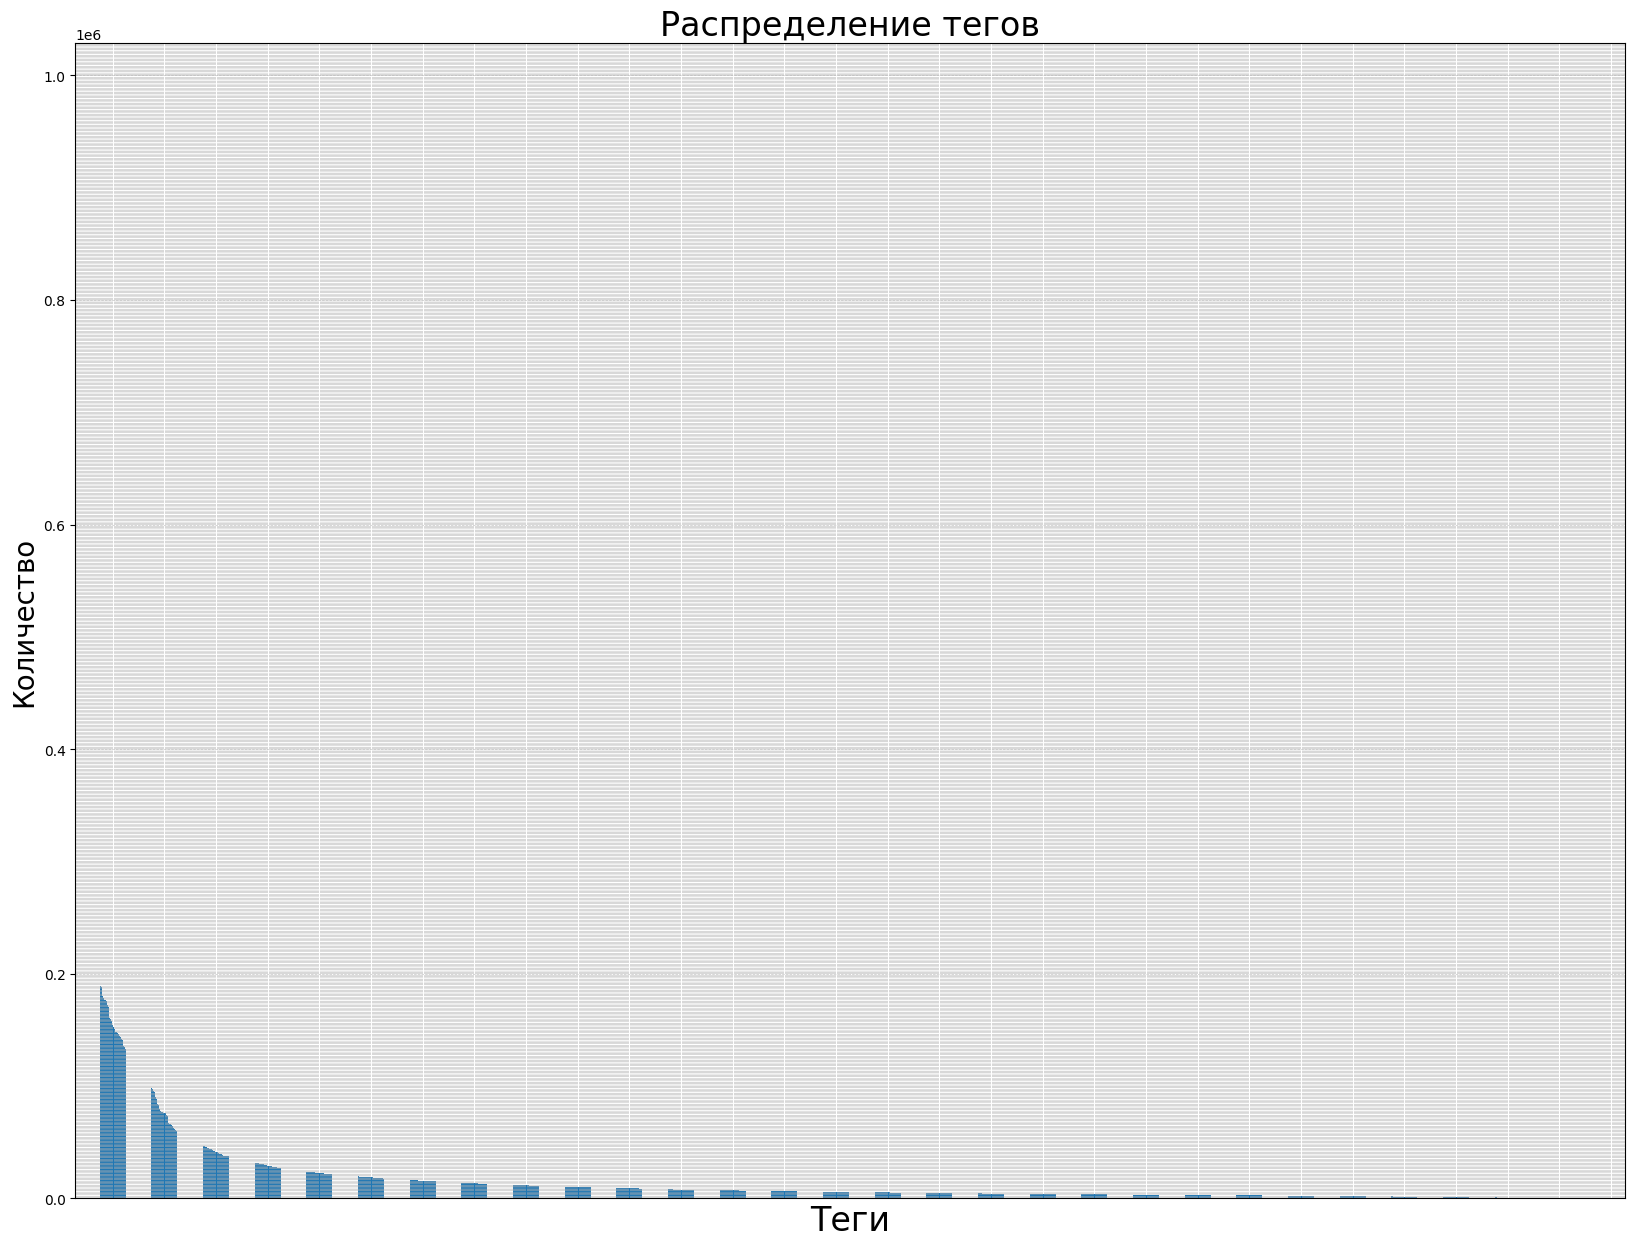

Количество уникальных тегов 1520


In [7]:
# создаем фигуру и оси
fig, ax = plt.subplots(figsize=(20, 15))

# построение бар-чарта
merged_df['tags'].value_counts().plot(kind='bar', ax=ax)

# настройка заголовка и меток осей
ax.set_title('Распределение тегов', fontsize=24)
ax.set_xlabel('Теги', fontsize=24)
ax.set_ylabel('Количество', fontsize=20)

# убираем подписи колонок
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# добавление сетки
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# отображение графика
plt.show()
print(f"Количество уникальных тегов {merged_df['tags'].nunique()}")

По графику можно выделить ~30 бинов

In [19]:
# разобъём теги по бинам 
merged_df["tags_by_bins"] = pd.cut(
    merged_df["tags"], bins=range(0, 1521, 50), labels=range(30)
)

In [20]:
# удалим столбец tags
merged_df.drop("tags", axis=1, inplace=True)

In [10]:
merged_df.head() # просмотр результата

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly,bundle_id,correct_answer,part,tag,type_of,tags_by_bins
0,1364845.236,607823552,2959,False,1250,0,30.667,True,0,1920,1.0,4,151,4,1
1,85440.517,1066326842,791,False,26,0,17.000,True,0,791,3.0,2,151,4,18
2,1272.885,1213517054,9259,False,26,3,31.000,True,0,6734,2.0,5,151,4,18
3,407527.526,429458461,3579,False,58,1,25.000,True,1,2147,1.0,5,151,4,24
4,7591662.270,1276214690,10217,False,2582,1,30.000,True,0,7535,0.0,6,151,4,28


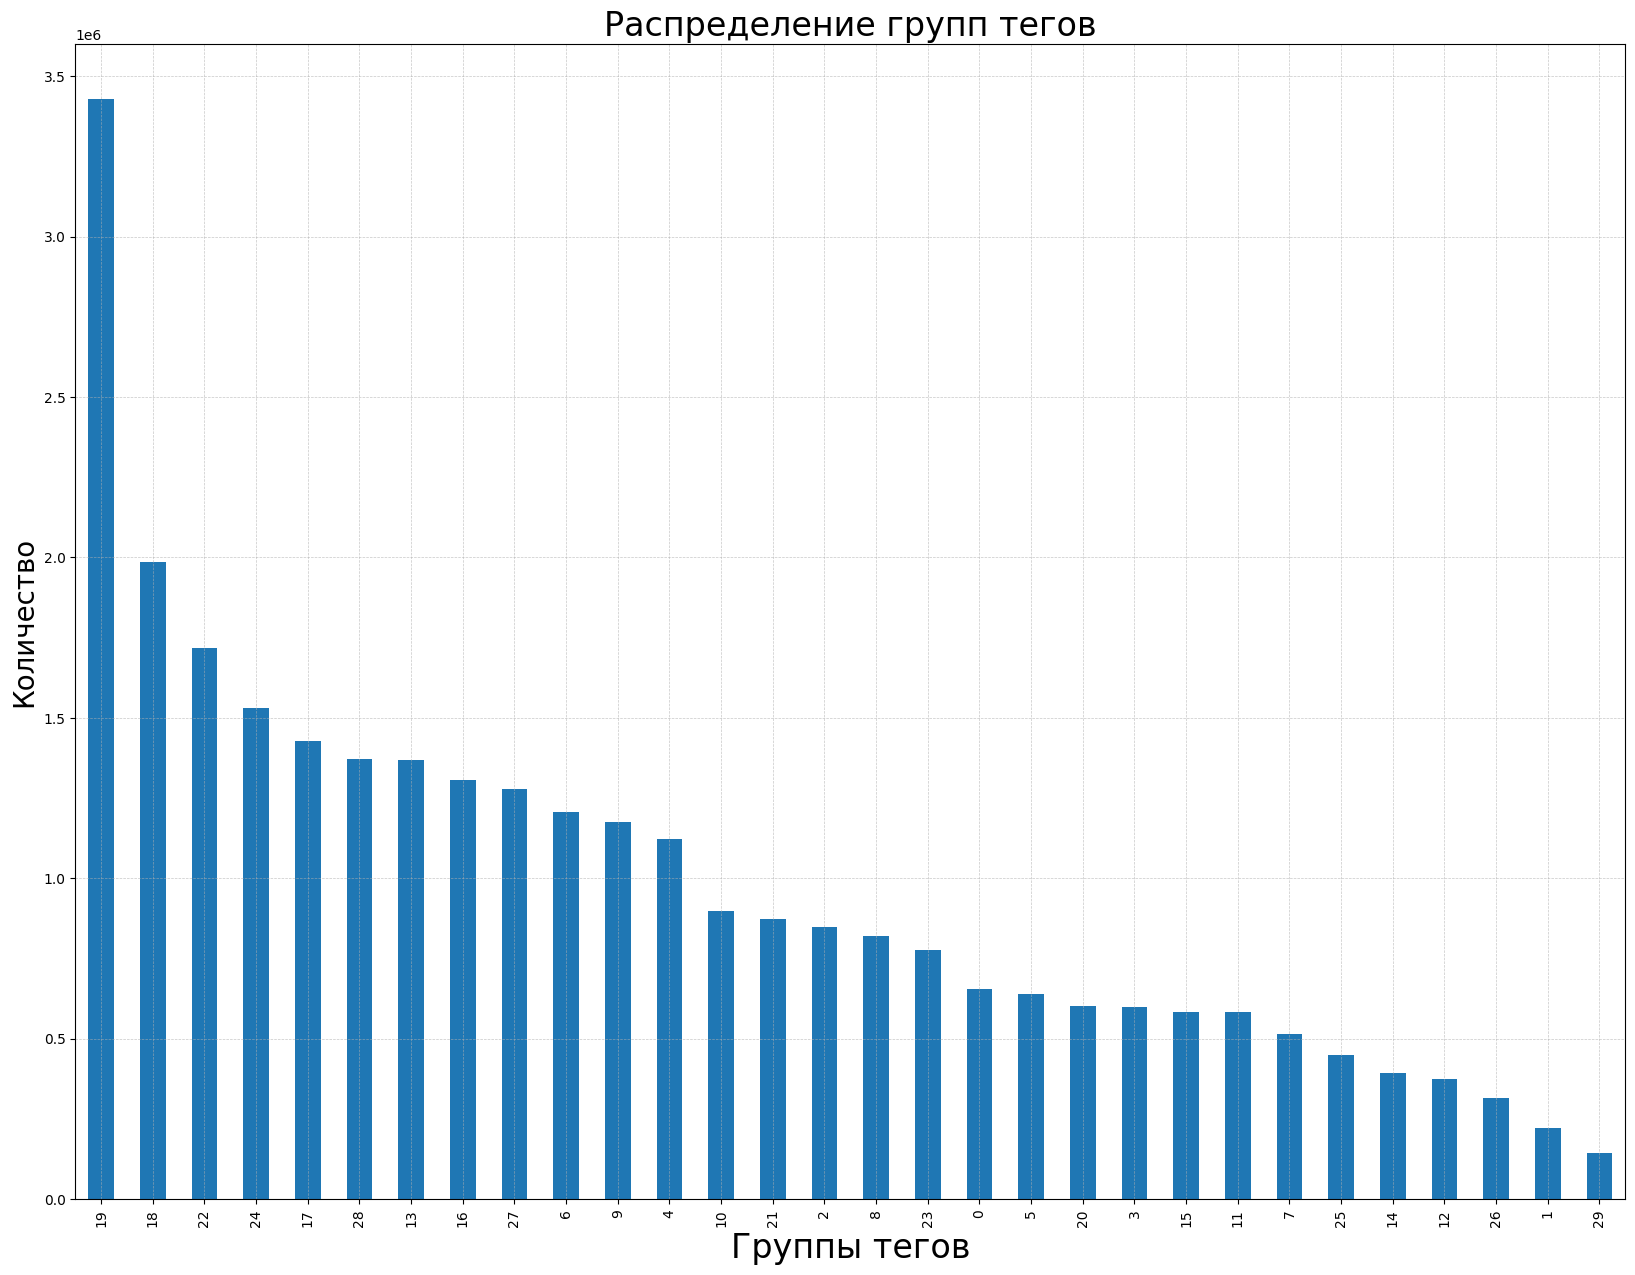

Количество групп тегов 30


In [28]:
# распределение частотности тегов, разделённых по бинам
# Создаем фигуру и оси
fig, ax = plt.subplots(figsize=(20, 15))

# Построение бар-чарта
merged_df["tags_by_bins"].value_counts().plot(kind="bar", ax=ax)

# Настройка заголовка и меток осей
ax.set_title('Распределение групп тегов', fontsize=24)
ax.set_xlabel('Группы тегов', fontsize=24)
ax.set_ylabel('Количество', fontsize=20)

# Добавление сетки
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Отображение графика
plt.show()

print(f"Количество групп тегов {merged_df['tags_by_bins'].nunique()}")

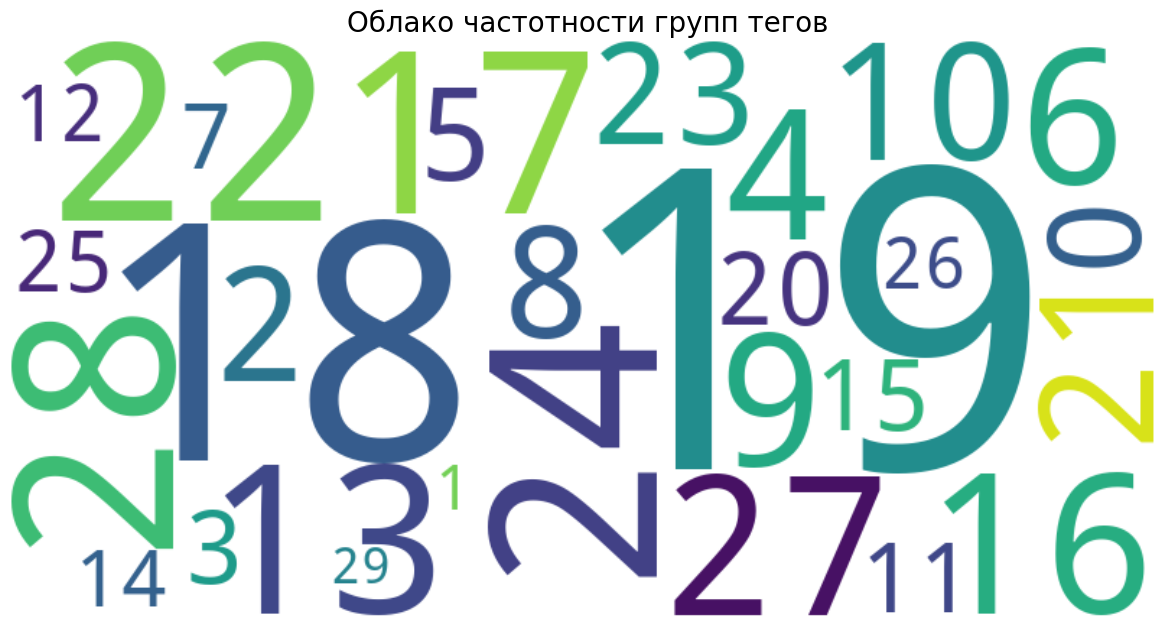

In [36]:
# построим облако частотности групп тегов
# Объединяем все строки в одну
all_tags_str = ' '.join(merged_df['tags_by_bins'].dropna().astype(str))

# Разбиваем строку на список тегов
all_tags_list = all_tags_str.split()

# Подсчитываем частоты тегов
tag_counts = Counter(all_tags_list)

# Создаём объект WordCloud
wordcloud = WordCloud(width=800, 
                      height=400, 
                      background_color='white').generate_from_frequencies(tag_counts)

# Визуализируем облако групп тегов
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако частотности групп тегов', fontsize=20)
plt.show()

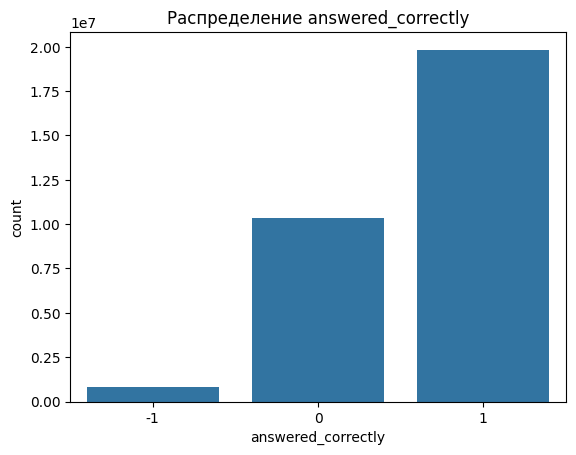

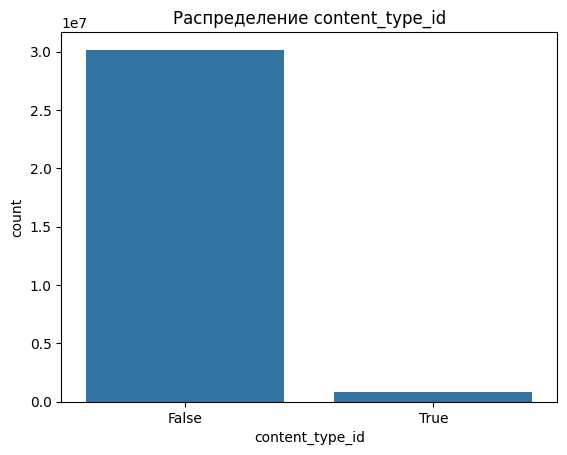

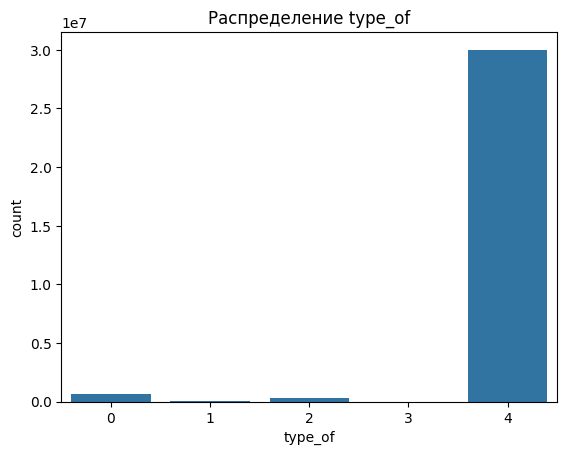

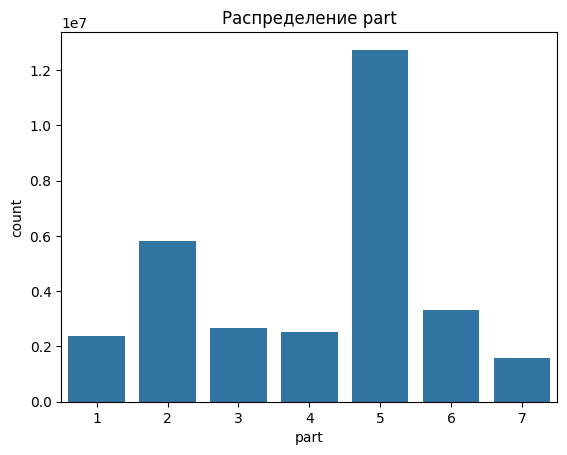

Количество меток ответа: 3
Количество типов контента: 2


In [21]:
# построение распределений значений
for column in ['answered_correctly', 'content_type_id', 'type_of', 'part']: 
    sns.countplot(x=column, data=merged_df)
    plt.title(f'Распределение {column}')
    plt.show()
print(f"Количество меток ответа: \
{merged_df['answered_correctly'].nunique()}")
print(f"Количество типов контента: \
{merged_df['content_type_id'].nunique()}")

По условию значение -1 для таргета обозначает Nan или отсутствие ответа, поскольку тип контента - лекция. Мы можем свести будущую модель к бинарной классификации, если избавимся от строк со значением -1 у таргета.

Самая популярная категория вопросов - 5

In [22]:
# фильтрация датасета (удаление строк со значением таргета -1)
merged_df = merged_df[merged_df["answered_correctly"] != -1]

In [15]:
# количество уникальных пользователей
print(f"Количество уникальных пользователей: \
{merged_df['user_id'].nunique()}")

Количество уникальных пользователей: 393032


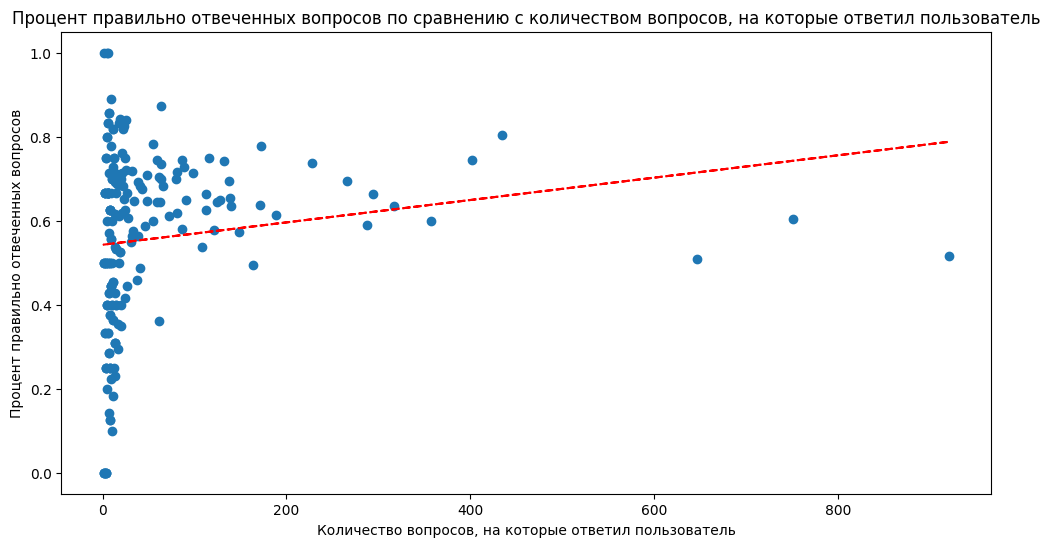

In [10]:
# скаттер с трендом
user_percent = merged_df.groupby("user_id")["answered_correctly"].agg(
    Mean="mean", Answers="count"
)

user_percent = user_percent.query("Answers <= 1000").sample(n=200, random_state=1)

fig = plt.figure(figsize=(12, 6))
x = user_percent.Answers
y = user_percent.Mean
plt.scatter(x, y, marker="o")
plt.title(
    "Процент правильно отвеченных вопросов по сравнению с количеством вопросов, на которые ответил пользователь"
)
plt.xticks(rotation=0)
plt.xlabel("Количество вопросов, на которые ответил пользователь")
plt.ylabel("Процент правильно отвеченных вопросов")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--")

plt.show()

Связь положительная:  с увеличением количества вопросов, на которые ответил пользователь, увеличивается процент вопросов с правильным ответом

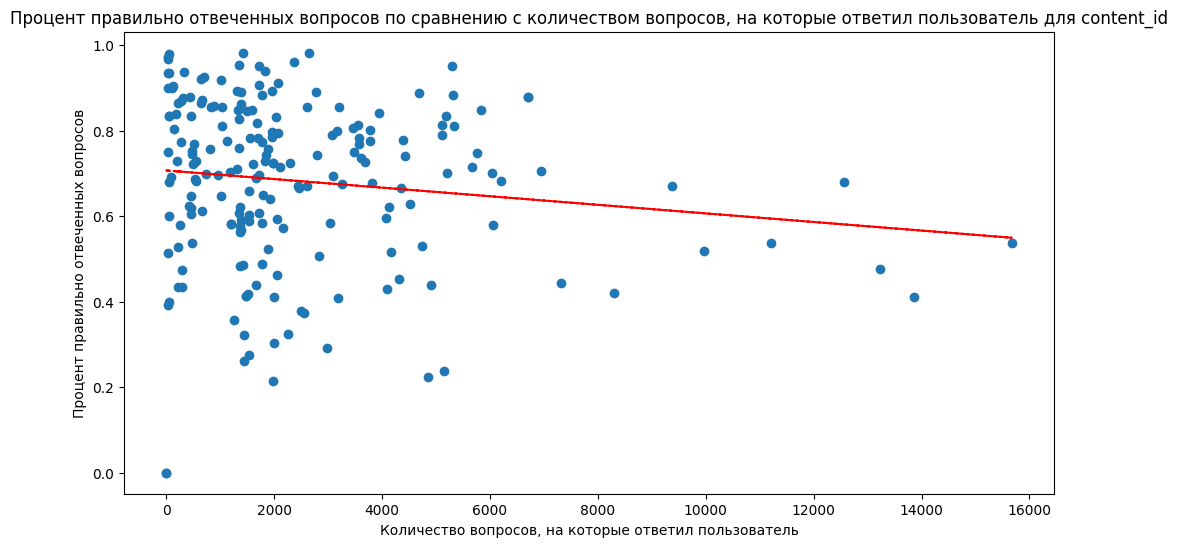

In [12]:
# рассмотрим с зависимость к content_id
content_percent = merged_df.groupby("content_id")["answered_correctly"].agg(
    Mean="mean", Answers="count"
)

content_percent = content_percent.query("Answers <= 25000").sample(
    n=200, random_state=1, replace=True
)

fig = plt.figure(figsize=(12, 6))
x = content_percent.Answers
y = content_percent.Mean
plt.scatter(x, y, marker="o")
plt.title(
    "Процент правильно отвеченных вопросов по сравнению с количеством вопросов, на которые ответил пользователь для content_id"
)
plt.xticks(rotation=0)
plt.xlabel("Количество вопросов, на которые ответил пользователь")
plt.ylabel("Процент правильно отвеченных вопросов")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--")

plt.show()

Наблюдается отрицательная связь: с увеличением количества отвеченных вопросов для content_id, уменьшается процент правильно отвеченных вопросов

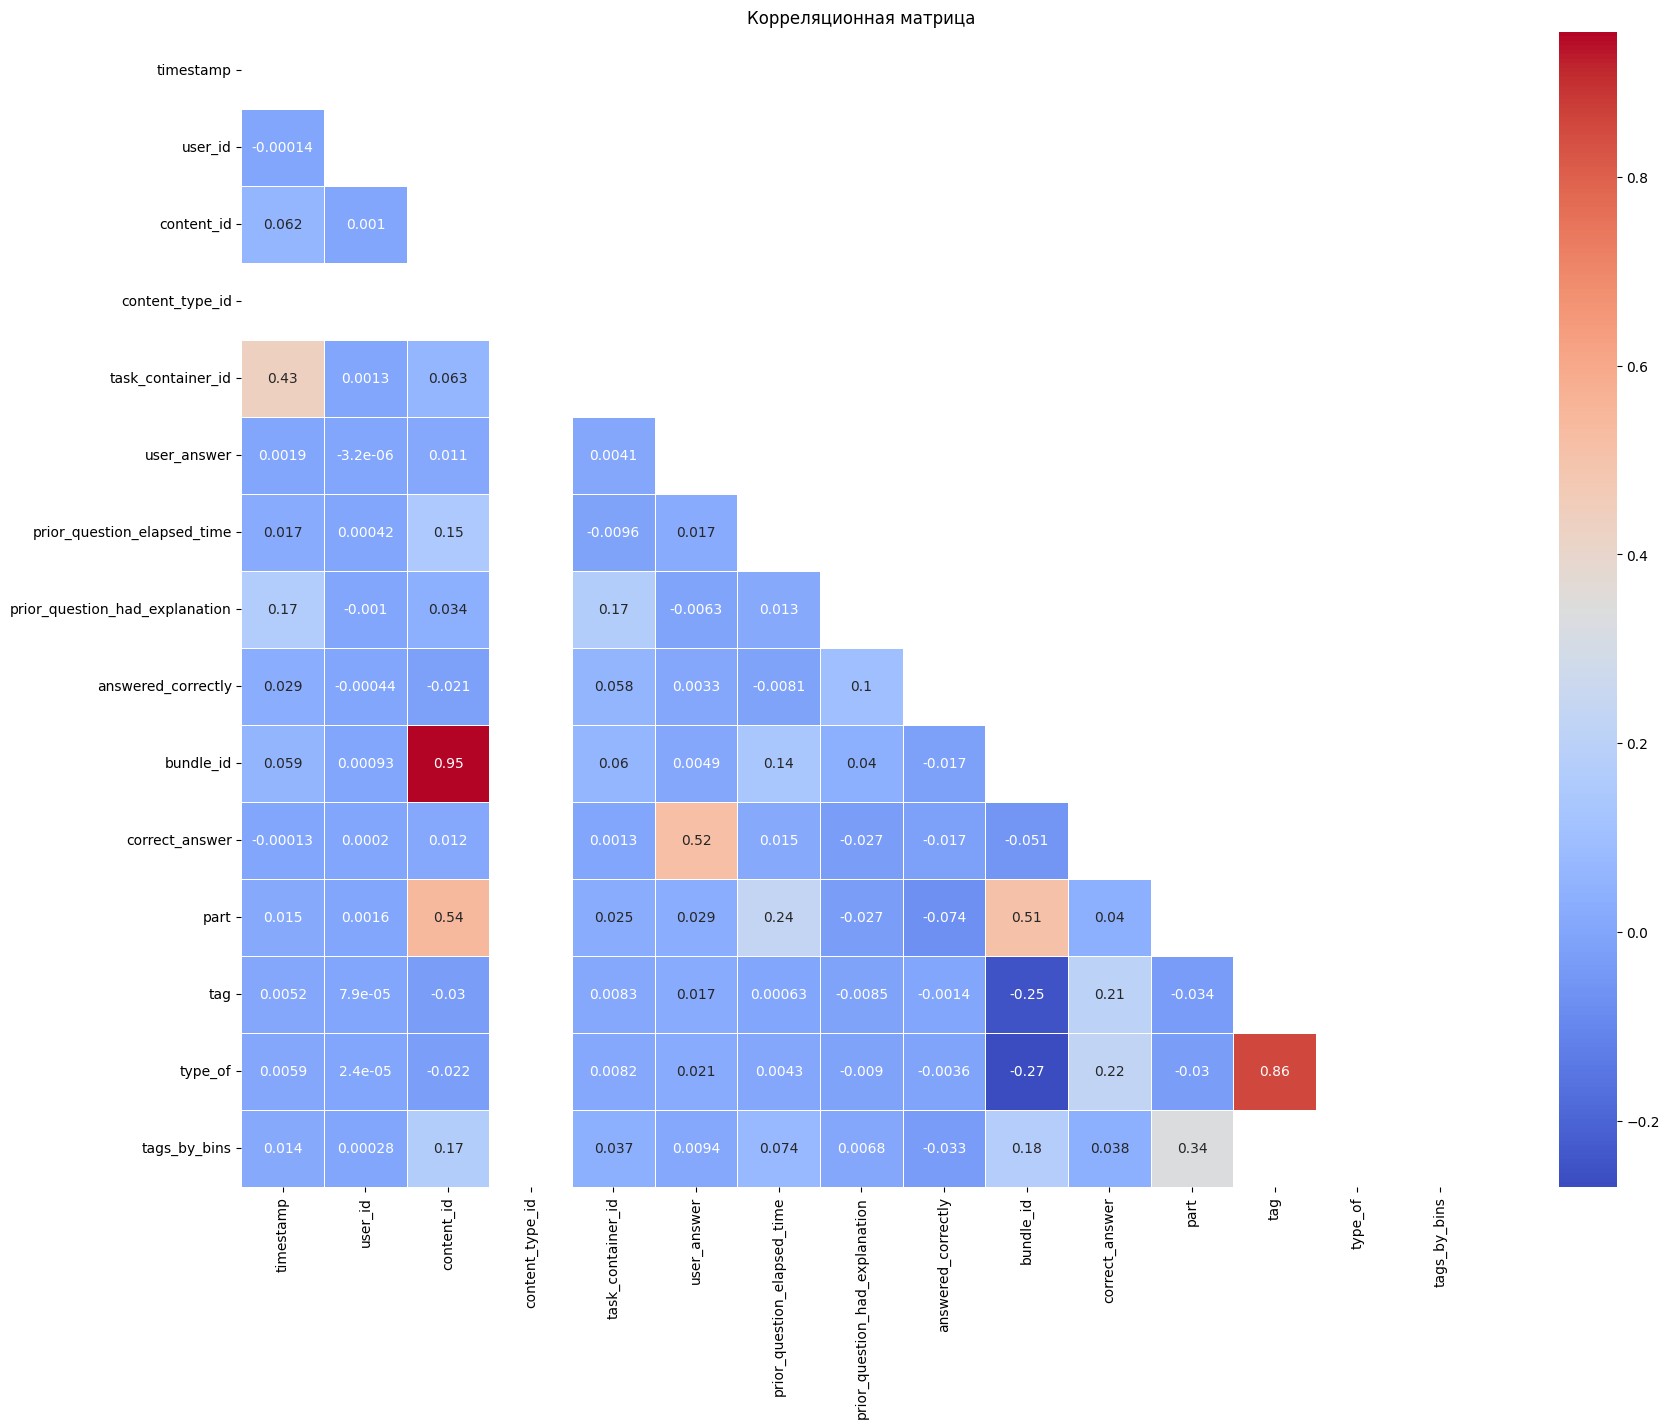

In [14]:
# Поиск корреляций между переменными и удаление мультиколлинеарности

# Корреляционная матрица
corr_matrix = merged_df.corr()

# Создание маски для верхней треугольной части матрицы
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Визуализация
fig, axes = plt.subplots(1, 1, figsize=(20, 15))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Корреляционная матрица')
plt.show()

In [14]:
# проверка на мультиколлениарность нелинейной зависимости
numeric_cols = merged_df.select_dtypes(include=['int64', 'float64'])
# удаление строк с пропусками
numeric_cols_cleaned = numeric_cols.dropna()

# добавляем константу для вычисления VIF
X = sm.add_constant(numeric_cols_cleaned)

# рассчитываем VIF для каждого признака
vif_data = pd.DataFrame()
vif_data["Признак"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

c:\USERS\GOGCO\ANACONDA3\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,Признак,VIF
0,const,0.000000
1,timestamp,1.236150
2,user_id,1.000005
3,content_id,24.014488
4,task_container_id,1.239588
5,user_answer,1.387071
6,prior_question_elapsed_time,1.061195
7,answered_correctly,1.010042
8,bundle_id,24.815875
9,correct_answer,1.461161


Мультиколлинеарность:
- Cильная корреляция между type_of и tag/content_type_id, влияние на таргет меньше у tag. За счет того что есть вероятность мультиколлинеарности с content_type_id, убираем type_of

- Сильная корреляция между bundle_id и content_id, влияние на таргет (answered corretly) меньше у bundle_id, следовательно убираем (VIF > 5)

- user_id можно удалить, поскольку имеет минимальное влияние на target (при ухудшении метрик во время обучения - удаляем)

In [23]:
# уберём колонки
merged_df.drop(
    columns=[
        "bundle_id",
        "user_id",
        "type_of"
    ], inplace=True
)

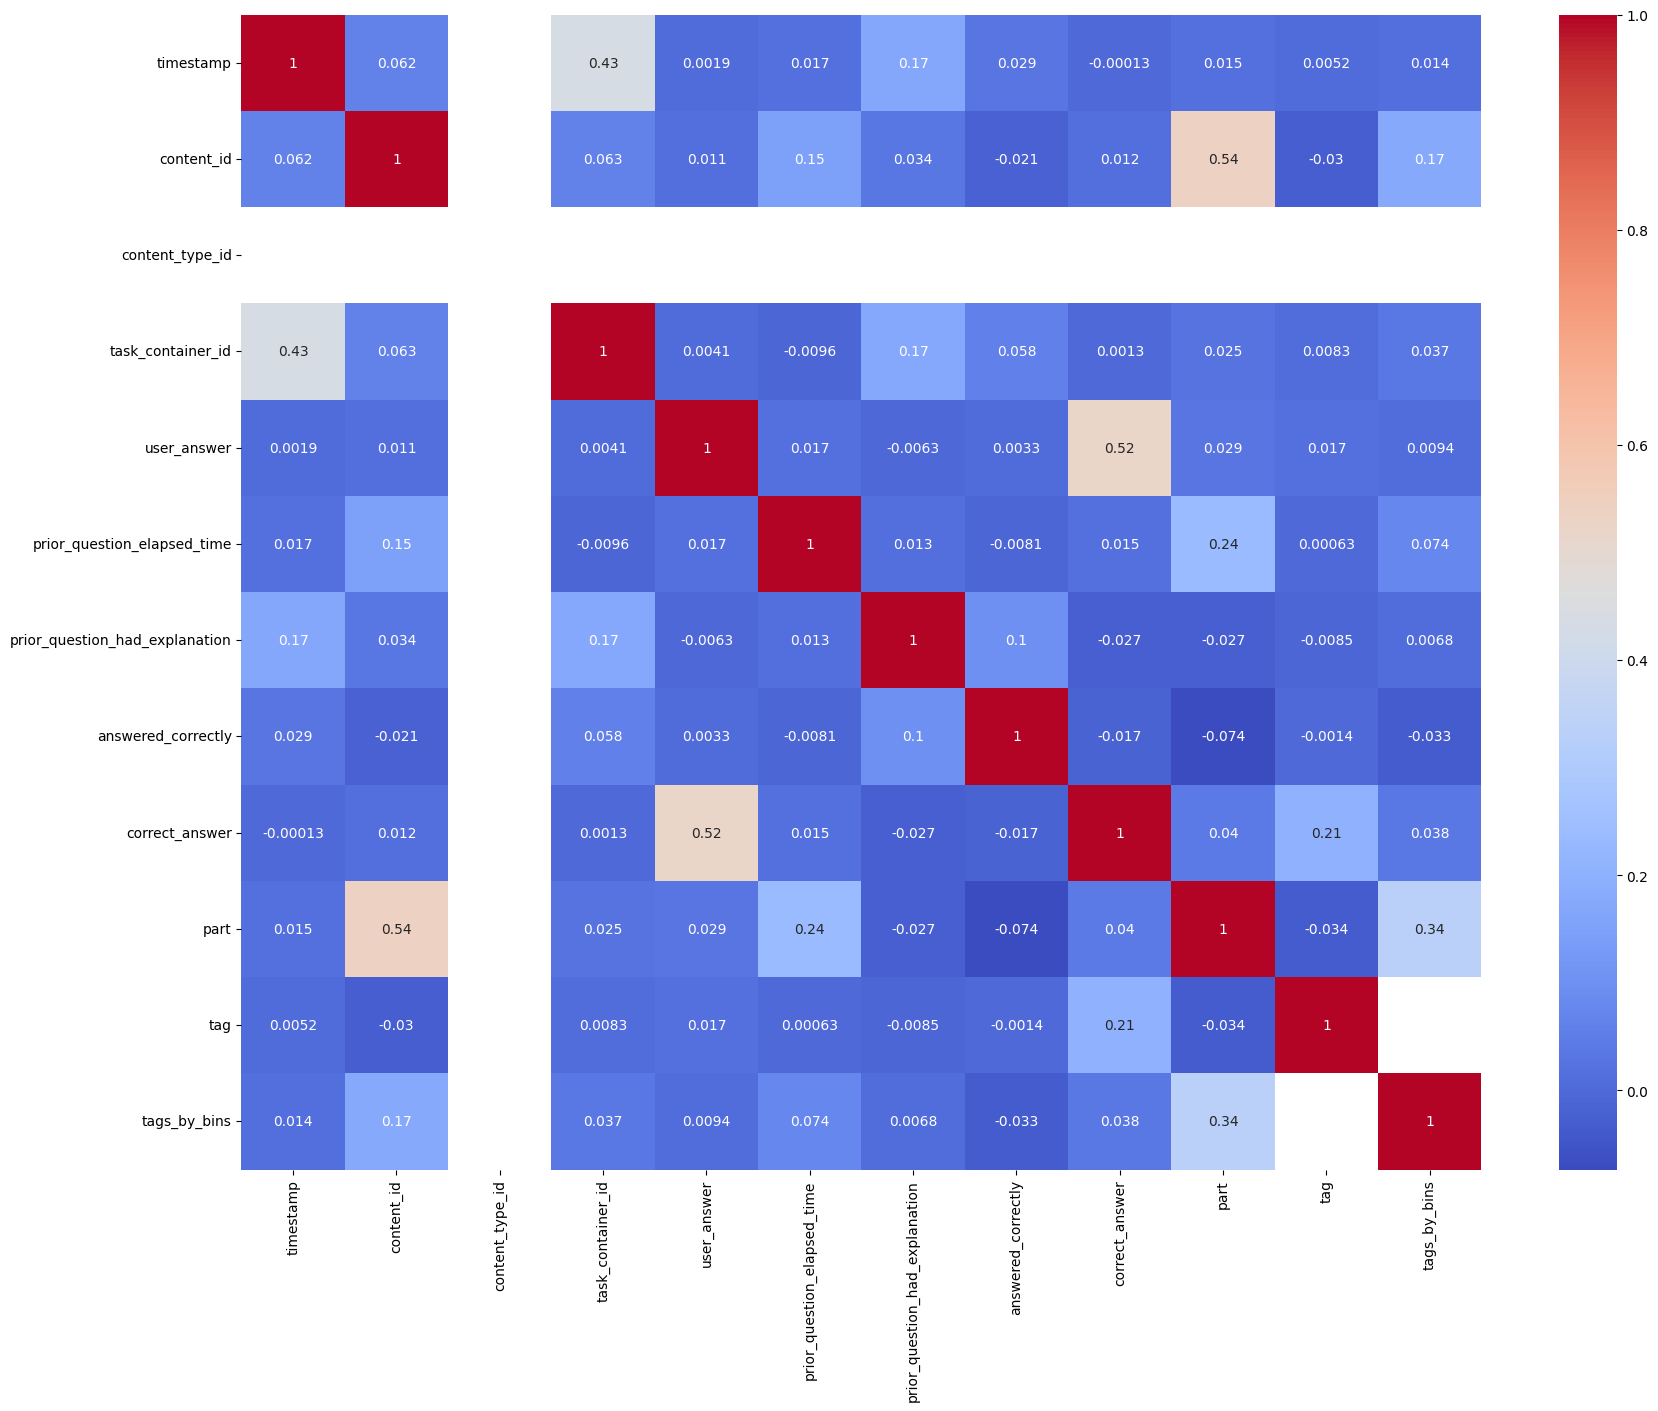

In [24]:
# наличие констант и просмотр матрицы корреляции после удаления
correlation_matrix = merged_df.corr()
fig, axes = plt.subplots(1, 1, figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=axes)
plt.show()

Количество типов взаимодействия: 1


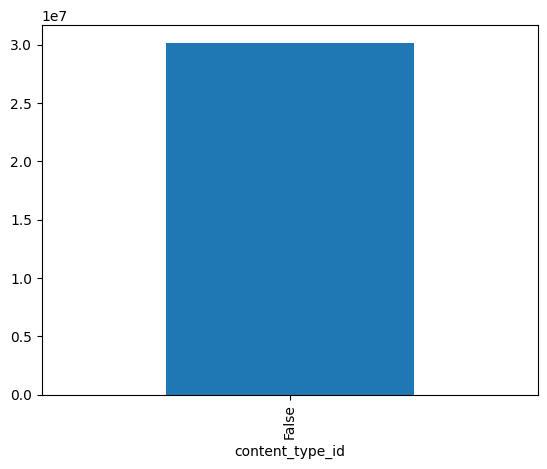

In [25]:
# распределение content_type_id
merged_df["content_type_id"].value_counts().plot(kind="bar")
print(f"Количество типов контента: \
{merged_df['content_type_id'].nunique()}")

In [26]:
# удалим данный признак, поскольку остались только вопросы
merged_df = merged_df.drop(columns=["content_type_id"], axis=1)

prior_question_had_explanation
False     2899487
True     27273602
Name: (answered_correctly, count), dtype: int64


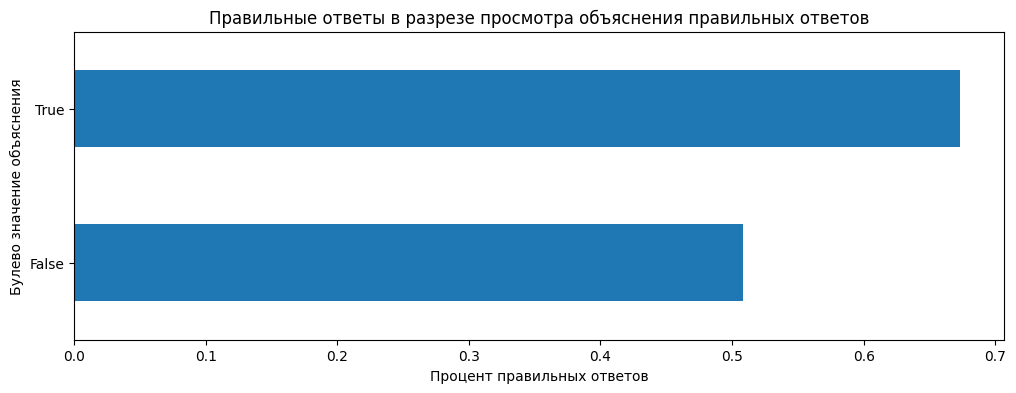

In [27]:
# prior_question_had_explanation
pq = merged_df.groupby(["prior_question_had_explanation"], dropna=False).agg(
    {"answered_correctly": ["mean", "count"]}
)

print(pq.iloc[:, 1])
pq = pq.iloc[:, 0]

fig = plt.figure(figsize=(12, 4))
pq.plot.barh()

plt.title("Правильные ответы в разрезе просмотра объяснения правильных ответов")
plt.xlabel("Процент правильных ответов")
plt.ylabel("Булево значение объяснения")
plt.xticks(rotation=0)
plt.show()

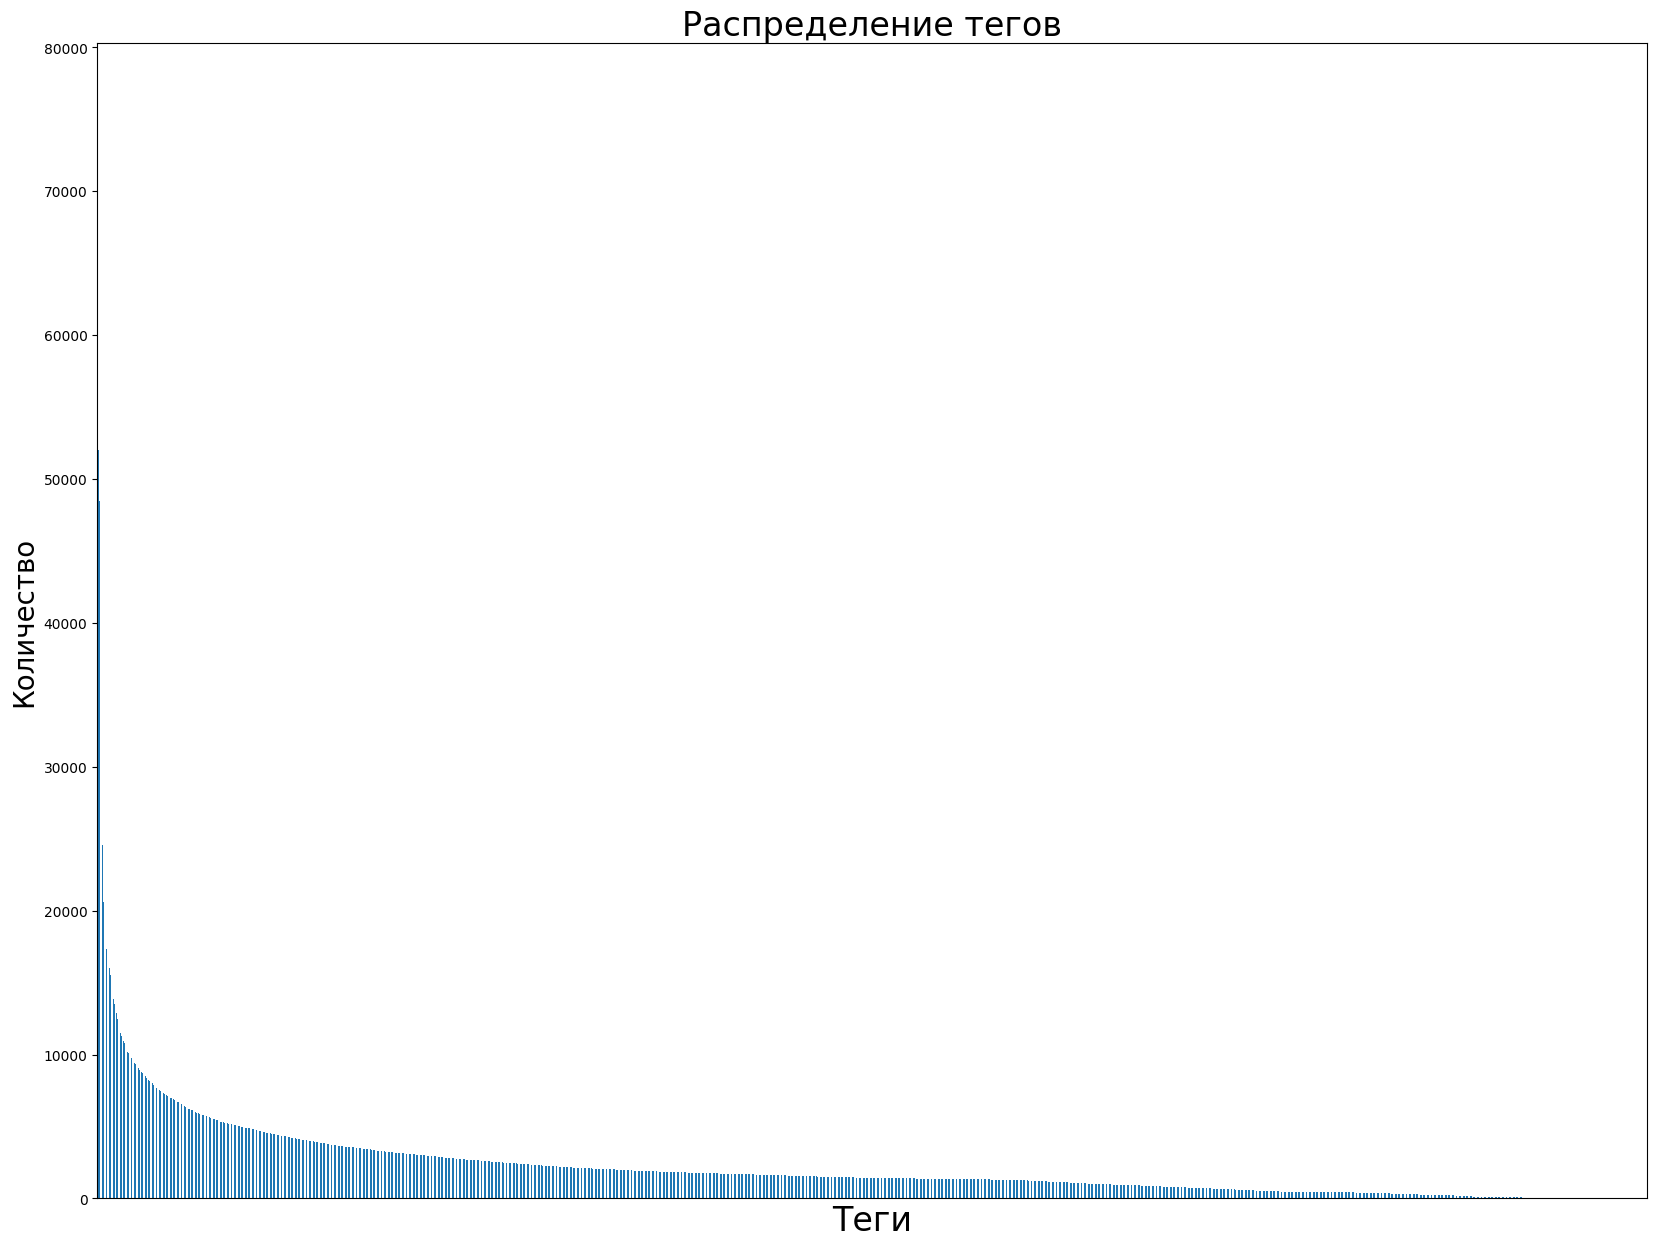

Количество уникальных id взаимодействия: 13516


In [30]:
# создаем фигуру и оси
fig, ax = plt.subplots(figsize=(20, 15))

# построение бар-чарта
merged_df['content_id'].value_counts().plot(kind='bar', ax=ax)

# настройка заголовка и меток осей
ax.set_title('Распределение тегов', fontsize=24)
ax.set_xlabel('Теги', fontsize=24)
ax.set_ylabel('Количество', fontsize=20)

# убираем подписи колонок
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# отображение графика
plt.show()
print(f"Количество уникальных id взаимодействия: \
{merged_df['content_id'].nunique()}")

Много уникальных значений id, которые тяжело разбить по пороговым значения и ввиду низкого влияния на таргет их можно удалить

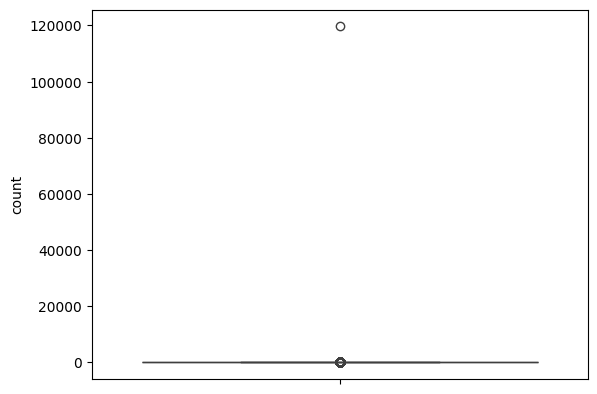

In [32]:
# выбросы timestamp
sns.boxplot(merged_df["timestamp"].value_counts())
plt.show()

Для уменьшения влияния выбросов используем логарифм 𝑦=log(𝑥+𝑐) 
Где:
c — константа сдвига, выбираемая так, чтобы 𝑥+𝑐>0 для всех значений 𝑥.
Часто используется c=1: 𝑦=log(𝑥+1)

In [33]:
# перевод в логарифмический масштаб
merged_df["timestamp"] = np.log(merged_df["timestamp"] + 1) 
# рассмотрение статистики
display(merged_df["timestamp"].describe())

count    3.017309e+07
mean     1.398284e+01
std      3.202076e+00
min      0.000000e+00
25%      1.315914e+01
50%      1.479557e+01
75%      1.610994e+01
max      1.828630e+01
Name: timestamp, dtype: float64

prior_question_had_explanation
False     2899487
True     27273602
Name: (answered_correctly, count), dtype: int64


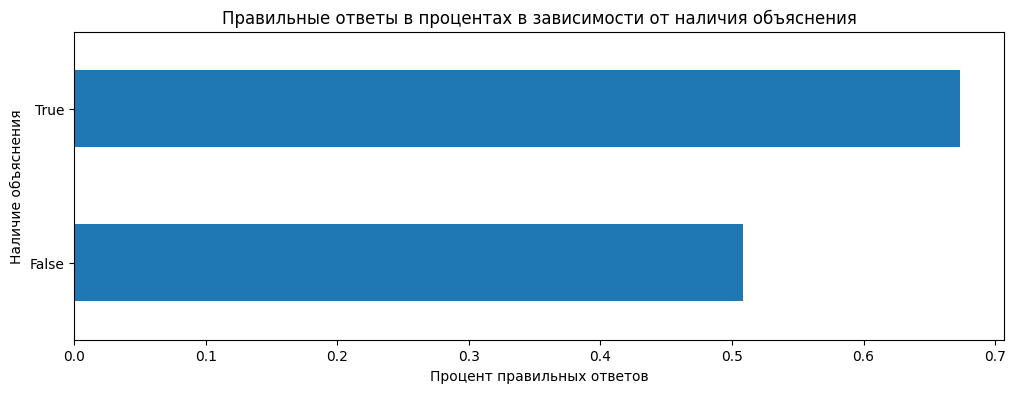

In [37]:
# prior_question_had_explanation
pq = merged_df.groupby(["prior_question_had_explanation"], dropna=False).agg(
    {"answered_correctly": ["mean", "count"]}
)

print(pq.iloc[:, 1])
pq = pq.iloc[:, 0]

fig = plt.figure(figsize=(12, 4))
pq.plot.barh()

plt.title("Правильные ответы в процентах в зависимости от наличия объяснения")
plt.xlabel("Процент правильных ответов")
plt.ylabel("Наличие объяснения")
plt.xticks(rotation=0)
plt.show()

После объяснение процент правильных ответов возрастает, что довольно реально

In [38]:
# проверка на наличие констант
merged_df[["tag", "tags_by_bins"]].value_counts()

tag  tags_by_bins
151  19              3410830
     18              1971828
     22              1688782
     24              1510595
     17              1411112
     13              1368119
     28              1355232
     16              1301873
     27              1269799
     6               1198074
     9               1172358
     4               1121208
     10               893651
     21               867039
     2                836569
     8                806808
     23               771442
     0                651375
     5                619996
     20               598884
     3                591989
     11               582119
     15               575828
     7                513171
     25               444720
     14               391743
     12               373412
     26               315633
     1                222301
     29               141678
Name: count, dtype: int64

In [39]:
# tag - константа (удаляем)
merged_df = merged_df.drop(columns=["tag"], axis=1)

Коэффициент асимметрии: 0.33


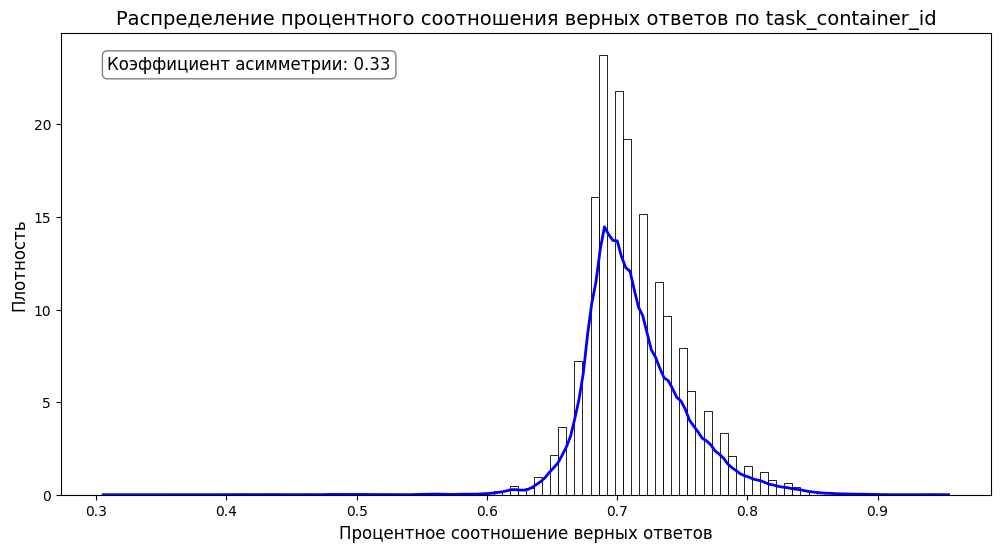

In [61]:
# Расчёт процента правильных ответов относительно task_container_id
correct_data = (
    merged_df[merged_df.answered_correctly != -1]
    .groupby(["task_container_id", "answered_correctly"])
    .size()
    .unstack(fill_value=0)
)

correct_data["Percent_correct"] = round(
    correct_data[1] / (correct_data[0] + correct_data[1]), 2
)

# Сортировка данных по проценту правильных ответов
correct_data.sort_values(by="Percent_correct", ascending=False, inplace=True)

# Расчёт коэффициента асимметрии
skewness = correct_data["Percent_correct"].skew()
print(f"Коэффициент асимметрии: {skewness:.2f}")

# Подготовка данных для построения графика
task_id_correct = correct_data["Percent_correct"]

fig, ax = plt.subplots(figsize=(12, 6))

# Построение нормализованной гистограммы
sns.histplot(
    task_id_correct,
    bins=100,
    kde=False,
    color='white',
    edgecolor='black',
    stat='density',
    ax=ax
)

# Наложение KDE-кривой с настройкой ширины ядра
sns.kdeplot(
    task_id_correct,
    color='blue',
    linewidth=2,
    bw_adjust=0.8,  # Попробуйте разные значения
    ax=ax
)

# Настройка графика
ax.set_title(
    "Распределение процентного соотношения верных ответов по task_container_id",
    fontsize=14
)
ax.set_xlabel("Процентное соотношение верных ответов", fontsize=12)
ax.set_ylabel("Частота", fontsize=12)

# Отображение коэффициента асимметрии на графике
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
textstr = f"Коэффициент асимметрии: {skewness:.2f}"
ax.text(
    0.05,
    0.95,
    textstr,
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=props
)

plt.show()


Распределение близко к нормальному с коэффициентом ассиметрии 0.33

In [72]:
# Составим матрицу статистик
pq_elapse = merged_df.groupby(["answered_correctly"]).agg(
    {"answered_correctly": ["count"], "prior_question_elapsed_time": ["mean"]}
)
display(pq_elapse)


,answered_correctly,prior_question_elapsed_time
,count,mean
answered_correctly,,
0,10336945,25.545492
1,19836144,25.204223


Среднее затраченное время на ответ незначительно влияет на таргет

In [76]:
# проверка на наличие утечек: признак correct_answer может быть утечкой (может привести к плохой метрике при работе модели на реальных данных)
answer_df = merged_df[["user_answer", "correct_answer", "answered_correctly"]]
answer_df[answer_df["correct_answer"] == -1]

,user_answer,correct_answer,answered_correctly
30011703,1,-1.0,0
30011704,1,-1.0,1
30011706,3,-1.0,1
30011707,1,-1.0,1
30011709,3,-1.0,0
...,...,...,...
30991090,0,-1.0,1
30991095,3,-1.0,1
30991100,1,-1.0,1
30991101,1,-1.0,0


Следует удалить все строки с correct_answer = -1, так как это могут быть или ошибки, или закодированные пустые значения

In [79]:
# удаляем строки
merged_df = merged_df[merged_df["correct_answer"] != -1]

Проверка на утечку: для этого сравним значения user_answer и correct_answer, результат check декодируем в булевое значение, после выведем все строки датасета,удовлетворяющие условию неравенства check и answered_correctly

In [82]:

answer_df = merged_df[["user_answer", "correct_answer", "answered_correctly"]]
answer_df["check"] = answer_df["user_answer"] == answer_df["correct_answer"]
answer_df["check"] = answer_df["check"].replace({True: 1, False: 0})

display(answer_df[answer_df["check"] != answer_df["answered_correctly"]])

,user_answer,correct_answer,answered_correctly,check


Данные признак являются утечкой - удаляем

In [83]:
merged_df.drop(columns=["user_answer", "correct_answer"], axis=1, inplace=True)

Построение матрицы корреляции

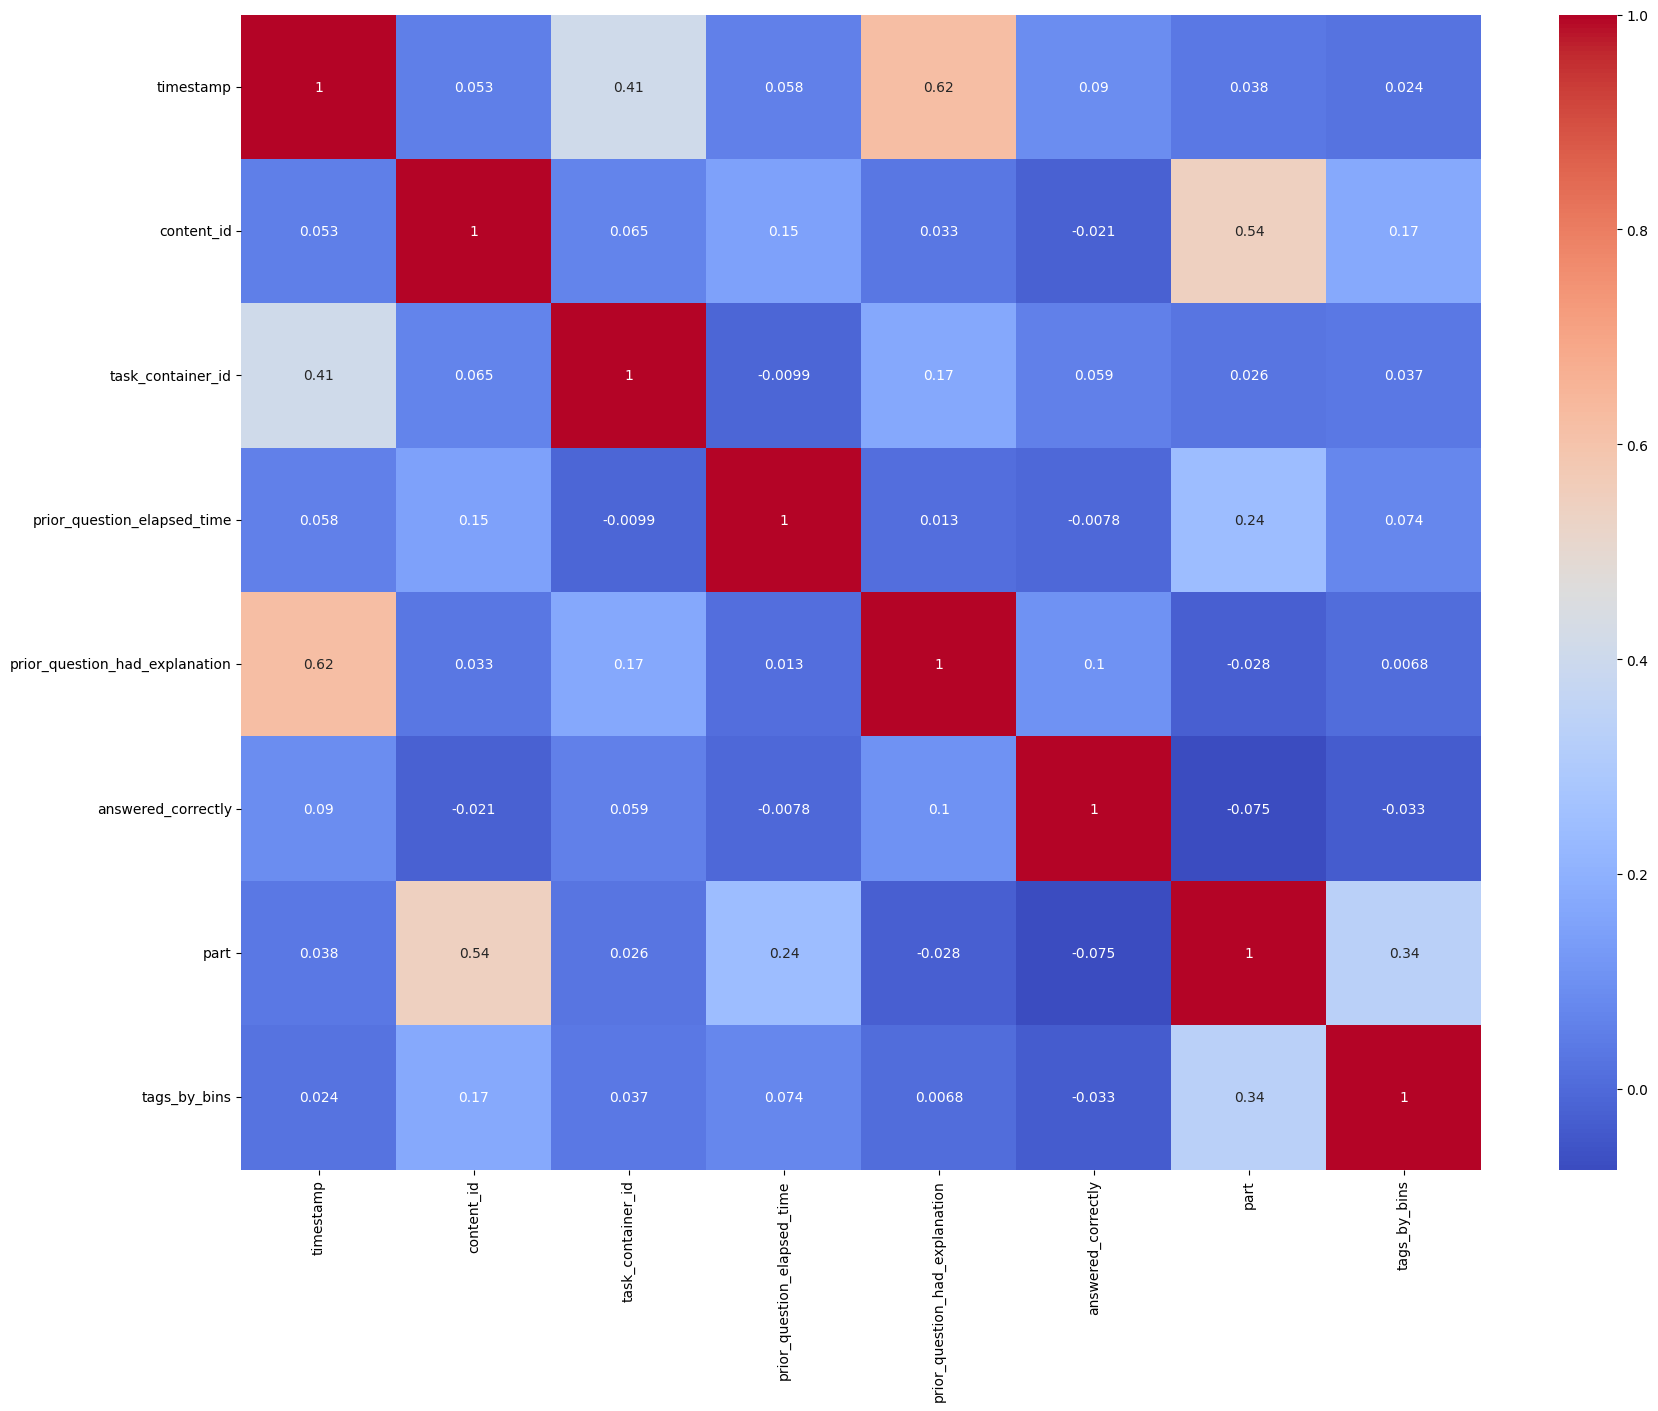

In [84]:
correlation_matrix = merged_df.corr()
fig, axes = plt.subplots(1, 1, figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=axes)
plt.show()

Сохраняется вероятность мультиколлениарности между timestamp и prior_question_had_explanation и между part и content_id. Можно попробовать использовать UMAP, PCA, FA, LDA.